In [57]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy
np.random.seed(67)

In [58]:
d = 3

In [59]:
def save_list(list_to_save, filename):
    filename = f"results/{filename}"
    with open(filename, 'w') as file:
        for item in list_to_save:
            file.write(str(item) + '\n')
    print(f"List saved to {filename}")

def load_list(filename):
    filename = f"results/{filename}"
    try:
        with open(filename, 'r') as file:
            return [complex(line.strip()) for line in file.readlines()]
    except FileNotFoundError:
        print(f"File {filename} not found.")
        return []

In [60]:
import qutip as qt
coherent_states = qt.coherent(3, 1)
coherent_states
def product_state(ttn, bond_dim=2 , physical_dim= 2):
    product_state = deepcopy(ttn)
    A = np.asarray(d*[1j/np.sqrt(physical_dim)])
    #A = np.asarray(coherent_states[:])
    for node_id in product_state.nodes.keys():
        n = product_state.tensors[node_id].ndim - 1
        tensor = A.reshape((1,) * n + (physical_dim,))
        T = np.pad(tensor, n*((0, bond_dim-1),) + ((0, 0),))
        product_state.tensors[node_id] = T
        product_state.nodes[node_id].link_tensor(T)  
    return product_state

In [61]:
shapes = {
    (0, 0): (2, 2, 2, d),
    (0, 1): (2, 2, d),
    (0, 2): (2, 2, d),
    (1, 0): (2, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, d),
    (2, 0): (2, 2, d),
    (2, 1): (2, 2, 2, d),
    (2, 2): (2, d)
}


sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(3) for j in range(3)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0)]


for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

# ttn = product_state(ttn , bond_dim= 2, physical_dim = d)

nodes = {
    (i, j): (ptn.Node(tensor=ttn.tensors[f"Site({i},{j})"].conj() , identifier=f"Node({i},{j})"), ttn.tensors[f"Site({i},{j})"].conj()) for i in range(3) for j in range(3)
}

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 2, "Site(0,0)", 2)

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

In [62]:
I = ptn.TTNO.Identity(ttn)
ptn.adjust_bra_to_ket(ttn)

for ket_id in list(ttn.nodes.keys())[0:len(ttn.nodes)//2]:
    i, j = ket_id.replace('Site(', '').replace(')', '').split(',')
    bra_id = f"Node({i},{j})"
    assert np.array_equal(ttn.tensors[ket_id].conj(), ttn.tensors[bra_id])

ttn = ptn.normalize_ttn_Lindblad(ttn)

for ket_id in list(ttn.nodes.keys())[0:len(ttn.nodes)//2]:
    i, j = ket_id.replace('Site(', '').replace(')', '').split(',')
    bra_id = f"Node({i},{j})"
    assert np.array_equal(ttn.tensors[ket_id].conj(), ttn.tensors[bra_id])

ttn.operator_expectation_value_Lindblad(I)


array(1.-6.9388939e-17j)

In [63]:
def Liouville(t, U, J, m, L, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)


    }
    
    conversion_dict.update({
        "it * b^dagger": t*1j * creation_op,
        "it * b": t*1j * annihilation_op,
        "-iU * n * (n - 1)": -U*1j * number_op @ (number_op - np.eye(d)),
        "m*n": m*number_op
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "m*n"}))        
    
    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t*1j * creation_op.T,
        "-it * b.T": -t*1j * annihilation_op.T,
        "iU * n * (n - 1).T": (U*1j * number_op @ (number_op - np.eye(d))).T,
        "-m*n.T": -m * number_op.T

    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Node({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", right_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", right_neighbor: "b^dagger.T"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Node({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", up_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", up_neighbor: "b^dagger.T"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))    

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-m*n.T"}))
            
    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)

    
    J = np.sqrt(J)
    conversion_dict = {    
    "L": J*L,
    "L^dagger.T": J*L.conj(),
    "-1/2 (L^dagger @ L) ": -1/2 * J *  L.conj().T @ L,
    "-1/2 (L^dagger @ L).T":-1/2 * J * (L.conj().T @ L).T}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            out_site = f"Node({x},{y})"
            in_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({in_site: "L"}))
            terms.append(ptn.TensorProduct({out_site: "L^dagger.T"}))
            terms.append(ptn.TensorProduct({in_site: "-1/2 (L^dagger @ L) "}))
            terms.append(ptn.TensorProduct({out_site: "-1/2 (L^dagger @ L).T"}))

    H3 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H3)
    return H1

In [64]:
def Unitary(t, U, m, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "it * b^dagger": t * 1.0j* creation_op,
        "it * b": t* 1.0j * annihilation_op,
        "-iU * n * (n - 1)": -U* 1.0j * number_op @ (number_op - np.eye(d)),
        "m*n": m * number_op

    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))
    
    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "m*n"}))

    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t* 1.0j * creation_op.T,
        "-it * b.T": -t* 1.0j * annihilation_op.T,
        "iU * n * (n - 1).T": (U* 1.0j* number_op @ (number_op - np.eye(d))).T,
        "-m*n.T": -m * number_op.T
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Node({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", right_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", right_neighbor: "b^dagger.T"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Node({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", up_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", up_neighbor: "b^dagger.T"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))   

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-m*n.T"}))         

    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)
    return H1

In [65]:
def BoseHubbard_ham(t, U, m, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)}
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d)),
        "-m*n": -m * number_op
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
    
    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-m*n"}))

    return ptn.Hamiltonian(terms, conversion_dict)

def BoseHubbard_ham_tp(t, U, Lx, Ly):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d))
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site:  -t * creation_op, right_neighbor: annihilation_op}))
                terms.append(ptn.TensorProduct({current_site: -t * annihilation_op, right_neighbor: creation_op}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site:  -t * creation_op, up_neighbor: annihilation_op}))
                terms.append(ptn.TensorProduct({current_site: -t * annihilation_op, up_neighbor: creation_op}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: U * number_op @ (number_op - np.eye(d))}))
    
    return terms

In [66]:
def Number_op_total(Lx, Ly, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "n"}))

    return ptn.Hamiltonian(terms, conversion_dict)     

def Number_op_local( node_id , dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    terms.append(ptn.TensorProduct({node_id: "n"}))

    return ptn.Hamiltonian(terms, conversion_dict)

def Correlation_function(node_id1, node_id2, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{dim}": np.eye(dim)
    }
    
    terms = []
    terms.append(ptn.TensorProduct({node_id1: "b^dagger", node_id2: "b"}))
    return ptn.Hamiltonian(terms, conversion_dict)

In [67]:
def exchange_bra_ket_tensors(ttn):
    state = deepcopy(ttn)
    ptn.adjust_bra_to_ket(state)
    for ket_id in list(state.nodes.keys())[:(len(state.nodes.keys())//2)]:
        i, j = ket_id.replace('Site(', '').replace(')', '').split(',')
        bra_id = f"Node({i},{j})"
        T1 = state.tensors[bra_id]
        T2 = state.tensors[ket_id]
        state.tensors[ket_id] = T1
        state.nodes[ket_id].link_tensor(T1)
        state.tensors[bra_id] = T2
        state.nodes[bra_id].link_tensor(T2)
    return state

def substitute_out_or_in_legs_of_ttn_with_identity(state, out_or_in , bond_dim=2):
    ttn = deepcopy(state)
    if out_or_in == "Out":
       for node_id in list(ttn.nodes.keys())[(len(ttn.nodes.keys())//2):]:
        n = ttn.tensors[node_id].ndim - 1
        T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
        T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
        ttn.tensors[node_id] = T
        ttn.nodes[node_id].link_tensor(T)   
    if out_or_in == "In":
        for node_id in list(ttn.nodes.keys())[:len(ttn.nodes.keys())//2]:
            n = ttn.tensors[node_id].ndim
            T = ttn.tensors[node_id]
            T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
            T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
            ttn.tensors[node_id] = T
            ttn.nodes[node_id].link_tensor(T)        
    return ttn


In [68]:
t = 1
U = 1
m = 1

# TTNO : Hamiltonian acting on in_legs
H1 = BoseHubbard_ham(t, U, m, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
H = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Liouville operator 
creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
L = creation_op 
J = 4
H1 = Liouville(t, U, J, m ,L, 3, 3, d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
L_fancy = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Unitary operator
H1 = Unitary(t, U, m, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
U = ptn.TTNO.from_hamiltonian(H1, ttn)

I = ptn.TTNO.Identity(ttn)

N = Number_op_total(3, 3, d)
N = N.pad_with_identities(ttn, symbolic= True)
N = ptn.TTNO.from_hamiltonian(N, ttn)

N1 = Number_op_local("Site(0,0)", d)
N1 = N1.pad_with_identities(ttn, symbolic= True)
N1 = ptn.TTNO.from_hamiltonian(N1, ttn)

# Correlation function
node_id1 = "Site(0,0)"
node_id2 = "Site(2,2)"
H1 = Correlation_function(node_id1, node_id2, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
Corr = ptn.TTNO.from_hamiltonian(H1, ttn)

print(ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(N))
print(ttn.operator_expectation_value_Lindblad(N1))
print(ttn.operator_expectation_value_Lindblad(H))
print(np.linalg.norm(ttn.operator_expectation_value_Lindblad(Corr)))


(0.9999999999999987-6.938893903907228e-17j)
(9.203620428254105-8.881784197001252e-16j)
(0.8938646652851301-8.326672684688674e-17j)
(-3.4799405205772715+3.885780586188048e-16j)
0.15118553008831048


In [69]:
n_site_dict = {}
for node in list(ttn.nodes.values())[:(len(ttn.nodes.keys())//2)]:
    node_id = node.identifier
    n_site = Number_op_local(node_id, d)
    n_site = n_site.pad_with_identities(ttn, symbolic=True)
    n_site = ptn.TTNO.from_hamiltonian(n_site, ttn)
    n_site_dict[f'n_{node_id}'] = n_site
n_site_list = list(n_site_dict.values())

In [70]:
#ttn = ptn.expand_subspace(ttn, U, 3, 0.001, ptn.SVDParameters(max_bond_dim = 24 , rel_tol= 1e-8 , total_tol = -np.inf)
#                          ,1e-30, ptn.KrylovBasisMode.apply_1st_order_expansion)
#ttn.max_bond_dim()

In [73]:
# Config : Lindblad = True
# time_evolve with exponent = hamiltonian * time_difference
# evaluate_operator with operator_expectation_value_Lindblad(operator)
# normalize_ttn_Lindblad after each run_one_time_step_ex

tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                     hamiltonian = L_fancy,
                                     time_step_size = 0.001,
                                     final_time = 0.1,
                                     operators = [I, H ,N, Corr],
                                     num_vecs = 3,
                                     tau = 1e-3,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = 20 , rel_tol= 1e-2 , total_tol = -np.inf),
                                     expansion_steps = 5,
                                     initial_tol= 1e-20,
                                     tol_step= 1,
                                     max_bond= 30,
                                     norm_tol= 0,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True,
                                                                         Lindblad = True) )

In [72]:
v

NameError: name 'v' is not defined

In [ ]:
ttn = tdvp_ex1.state
ttn = ptn.original_form(ttn,tdvp_ex1.two_neighbour_form_dict)
ttn = ptn.normalize_ttn_Lindblad(ttn)
ptn.adjust_bra_to_ket(ttn)
print(ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(N)/ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(N1)/ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(H)/ttn.operator_expectation_value_Lindblad(I))
print(np.linalg.norm(ttn.operator_expectation_value_Lindblad(Corr)))

(1.0000000000000016+1.942890293094024e-16j)
(9.271384308204086+4.1911779165491555e-16j)
(1.2011802245260124-1.223538373862931e-16j)
(-0.5106771401329374-3.171146683875031e-16j)
0.07423720710398042


In [74]:
tdvp_ex1.run_ex(evaluation_time=2)

times = tdvp_ex1.times()
tdvp_results_ex1 = tdvp_ex1.operator_results()[1]

100%|██████████| 101/101 [00:08<00:00, 12.13it/s]


In [ ]:
results_I = tdvp_ex1.operator_results()[0]
results_H = tdvp_ex1.operator_results()[1]
results_N = tdvp_ex1.operator_results()[2]
results_Corr = [np.linalg.norm(a) for a in tdvp_ex1.operator_results()[3]]
#save_list(results_H, "H_J=0.2")
results_H

array([-3.47994052+6.01446402e-16j, -3.47978828-2.38959710e-02j,
       -3.47923885-4.77989533e-02j, -3.47902227-7.18521605e-02j,
       -3.47896429-9.57751859e-02j, -3.47961584-1.19773863e-01j,
       -3.47919031-1.44127224e-01j, -3.48006641-1.68596303e-01j,
       -3.48037299-1.92993415e-01j, -3.48013825-2.17338151e-01j,
       -3.47938363-2.41647712e-01j, -3.4781244 -2.65935298e-01j,
       -3.47637162-2.90211358e-01j, -3.47413349-3.14484500e-01j,
       -3.47141631-3.38762076e-01j, -3.46822499-3.63050553e-01j,
       -3.46456345-3.87355768e-01j, -3.46043482-4.11683096e-01j,
       -3.45584164-4.36037555e-01j, -3.4507859 -4.60423874e-01j,
       -3.44526919-4.84846544e-01j, -3.43929268-5.09309853e-01j,
       -3.43285726-5.33817912e-01j, -3.42596351-5.58374683e-01j,
       -3.41861176-5.82983997e-01j, -3.41080208-6.07649567e-01j,
       -3.40253433-6.32375006e-01j, -3.39380813-6.57163834e-01j,
       -3.38462291-6.82019491e-01j, -3.37497785-7.06945342e-01j,
       -3.36487193-7.3194

In [ ]:
save_list(results_H, "H_(t,U,m,J)=(1,1,1,0.5)")
save_list(results_N , "N_(t,U,m,J)=(1,1,1,0.5)" )
save_list(results_Corr , "Corr_(t,U,m,J)=(1,1,1,0.5)" )

List saved to results/H_(t,U,m,J)=(1,1,1,0.5)
List saved to results/N_(t,U,m,J)=(1,1,1,0.5)
List saved to results/Corr_(t,U,m,J)=(1,1,1,0.5)


In [82]:
H = [-3.47994052+3.00321106e-16j, -3.47955261-2.13703137e-02j,
       -3.47876933-4.27419100e-02j, -3.47855819-6.42359328e-02j,
       -3.47862421-8.55744219e-02j, -3.47788012-1.06926130e-01j,
       -3.47884758-1.28434437e-01j, -3.4798439 -1.50033068e-01j,
       -3.4805605 -1.71619075e-01j, -3.48095265-1.93183019e-01j,
       -3.48100976-2.14726575e-01j, -3.48072746-2.36253191e-01j,
       -3.48010304-2.57766567e-01j, -3.47913442-2.79270360e-01j,
       -3.47781989-3.00768135e-01j, -3.47615795-3.22263379e-01j,
       -3.47414732-3.43759521e-01j, -3.47178685-3.65259947e-01j,
       -3.46907549-3.86768001e-01j, -3.46601232-4.08286984e-01j,
       -3.46259646-4.29820146e-01j, -3.45882712-4.51370693e-01j,
       -3.45470358-4.72941779e-01j, -3.45022514-4.94536506e-01j,
       -3.44539117-5.16157926e-01j, -3.44020104-5.37809040e-01j,
       -3.43465417-5.59492794e-01j, -3.42874999-5.81212081e-01j,
       -3.42248793-6.02969736e-01j, -3.41586742-6.24768540e-01j,
       -3.40888786-6.46611209e-01j, -3.40154864-6.68500403e-01j,
       -3.39384911-6.90438715e-01j, -3.3857886 -7.12428678e-01j,
       -3.37736635-7.34472759e-01j, -3.36858155-7.56573361e-01j,
       -3.35943334-7.78732823e-01j, -3.34992075-8.00953422e-01j,
       -3.34004274-8.23237373e-01j, -3.32979816-8.45586831e-01j,
       -3.31918574-8.68003890e-01j, -3.30820411-8.90490589e-01j,
       -3.29685177-9.13048909e-01j, -3.28512706-9.35680775e-01j,
       -3.2730282 -9.58388059e-01j, -3.26055321-9.81172577e-01j,
       -3.24769997-1.00403609e+00j, -3.23446618-1.02698032e+00j,
       -3.2208493 -1.05000691e+00j, -3.20684663-1.07311748e+00j,
       -3.19245522-1.09631357e+00j]

In [83]:
N = [9.20362043-1.05119483e-16j, 9.20362201-1.23859908e-03j,
       9.20354376-2.47605434e-03j, 9.20332297-3.76212684e-03j,
       9.20289571-5.00648135e-03j, 9.20239407-6.28460759e-03j,
       9.20169729-7.75938578e-03j, 9.20088069-9.17550426e-03j,
       9.19996074-1.05627487e-02j, 9.19894152-1.19312268e-02j,
       9.19782425-1.32862374e-02j, 9.19660934-1.46309292e-02j,
       9.19529696-1.59673567e-02j, 9.19388727-1.72969563e-02j,
       9.19238047-1.86207904e-02j, 9.19077683-1.99396849e-02j,
       9.18907669-2.12543084e-02j, 9.18728045-2.25652169e-02j,
       9.18538857-2.38728804e-02j, 9.18340155-2.51776995e-02j,
       9.18131997-2.64800164e-02j, 9.17914446-2.77801239e-02j,
       9.1768757 -2.90782716e-02j, 9.17451445-3.03746710e-02j,
       9.17206152-3.16694989e-02j, 9.16951776-3.29629004e-02j,
       9.16688409-3.42549909e-02j, 9.16416151-3.55458572e-02j,
       9.16135105-3.68355596e-02j, 9.15845382-3.81241321e-02j,
       9.15547098-3.94115834e-02j, 9.15240378-4.06978979e-02j,
       9.14925351-4.19830364e-02j, 9.14602156-4.32669368e-02j,
       9.14270938-4.45495150e-02j, 9.1393185 -4.58306663e-02j,
       9.13585055-4.71102664e-02j, 9.13230723-4.83881733e-02j,
       9.12869036-4.96642289e-02j, 9.12500185-5.09382613e-02j,
       9.12124371-5.22100874e-02j, 9.11741808-5.34795159e-02j,
       9.1135272 -5.47463507e-02j, 9.10957347-5.60103949e-02j,
       9.1055594 -5.72714552e-02j, 9.10148764-5.85293474e-02j,
       9.09736102-5.97839015e-02j, 9.09318251-6.10349686e-02j,
       9.08895526-6.22824280e-02j, 9.08468257-6.35261952e-02j,
       9.08036797-6.47662306e-02j]

In [84]:
Corr = [0.15118553008831065,
 0.15224006992760974,
 0.1532982011183182,
 0.15436090971358404,
 0.1554078147526842,
 0.15644671430058826,
 0.15734391736343026,
 0.15823684601173527,
 0.15913655491938553,
 0.16004218167068582,
 0.1609529154944039,
 0.16186829621757687,
 0.16278807550693716,
 0.1637121205923159,
 0.16464036113518804,
 0.16557275949525863,
 0.16650929281387047,
 0.16744994159186172,
 0.16839468239218722,
 0.169343483319073,
 0.17029630127440382,
 0.1712530803125978,
 0.17221375065618016,
 0.17317822813209846,
 0.17414641387282992,
 0.17511819419798824,
 0.17609344060644672,
 0.17707200984155347,
 0.1780537439893081,
 0.17903847058384842,
 0.18002600269792576,
 0.18101613899472008,
 0.18200866373002067,
 0.1830033466892396,
 0.183999943057053,
 0.1849981931925494,
 0.18599782233202,
 0.18699854018807222,
 0.18800004047622046,
 0.1890020003355155,
 0.19000407966939512,
 0.19100592039491052,
 0.19200714561464177,
 0.19300735869722477,
 0.1940061422908298,
 0.1950030572384138,
 0.195997641445106,
 0.1969894086558976,
 0.19797784718570763,
 0.19896241856811217,
 0.19994255616807266]

In [85]:
save_list(H, "H_(t,U,m,J)=(1,1,1,2)")
save_list(N, "N_(t,U,m,J)=(1,1,1,2)")
save_list(Corr, "Corr_(t,U,m,J)=(1,1,1,2)")


List saved to results/H_(t,U,m,J)=(1,1,1,2)
List saved to results/N_(t,U,m,J)=(1,1,1,2)
List saved to results/Corr_(t,U,m,J)=(1,1,1,2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


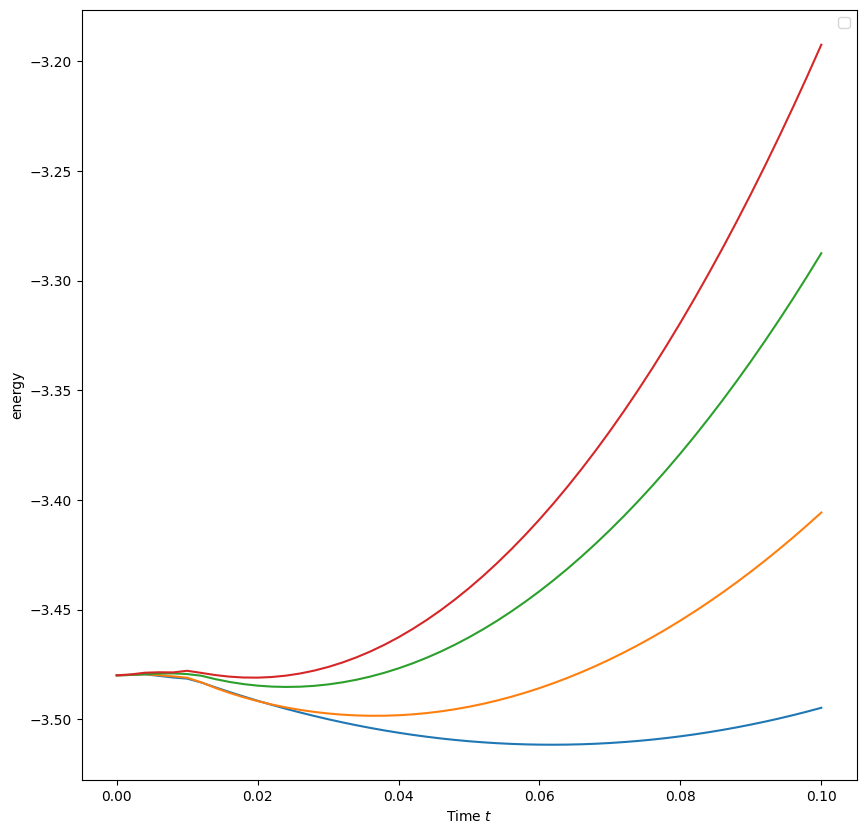

In [86]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(10,10))

axs1.plot(times, load_list("H_(t,U,m,J)=(1,1,1,0.5)") , label="")
axs1.plot(times, load_list("H_(t,U,m,J)=(1,1,1,1)") , label="")
axs1.plot(times, load_list("H_(t,U,m,J)=(1,1,1,1.5)") , label="")
axs1.plot(times, load_list("H_(t,U,m,J)=(1,1,1,2)") , label="")

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("energy")  
axs1.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


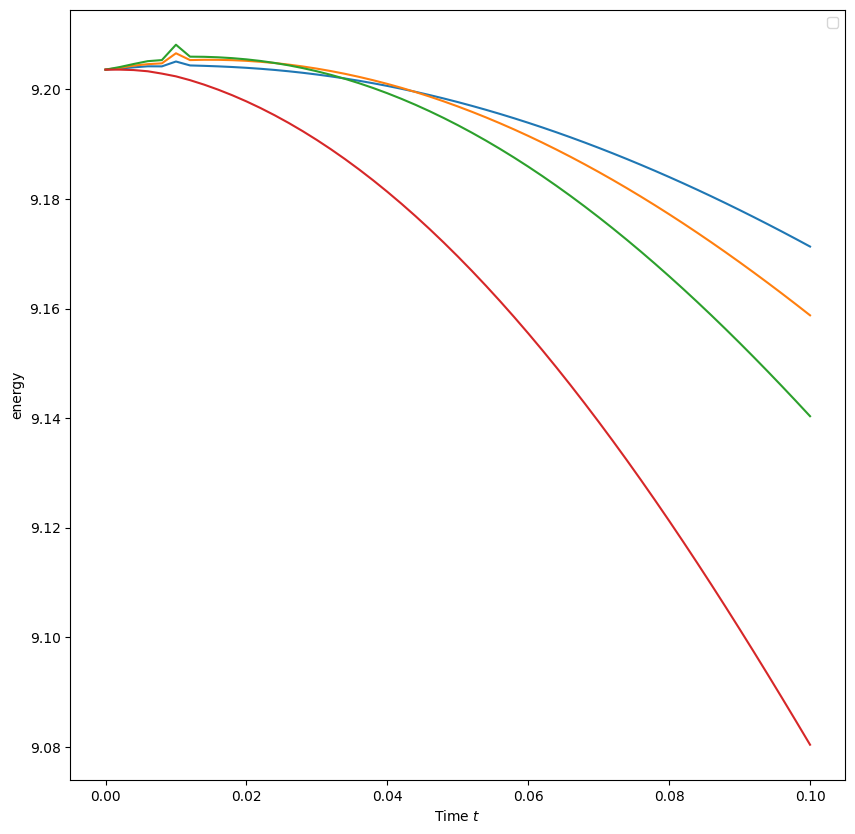

In [87]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(10,10))

axs1.plot(times, load_list("N_(t,U,m,J)=(1,1,1,0.5)") , label="")
axs1.plot(times, load_list("N_(t,U,m,J)=(1,1,1,1)") , label="")
axs1.plot(times, load_list("N_(t,U,m,J)=(1,1,1,1.5)") , label="")
axs1.plot(times, load_list("N_(t,U,m,J)=(1,1,1,2)") , label="")

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("energy")  
axs1.legend()

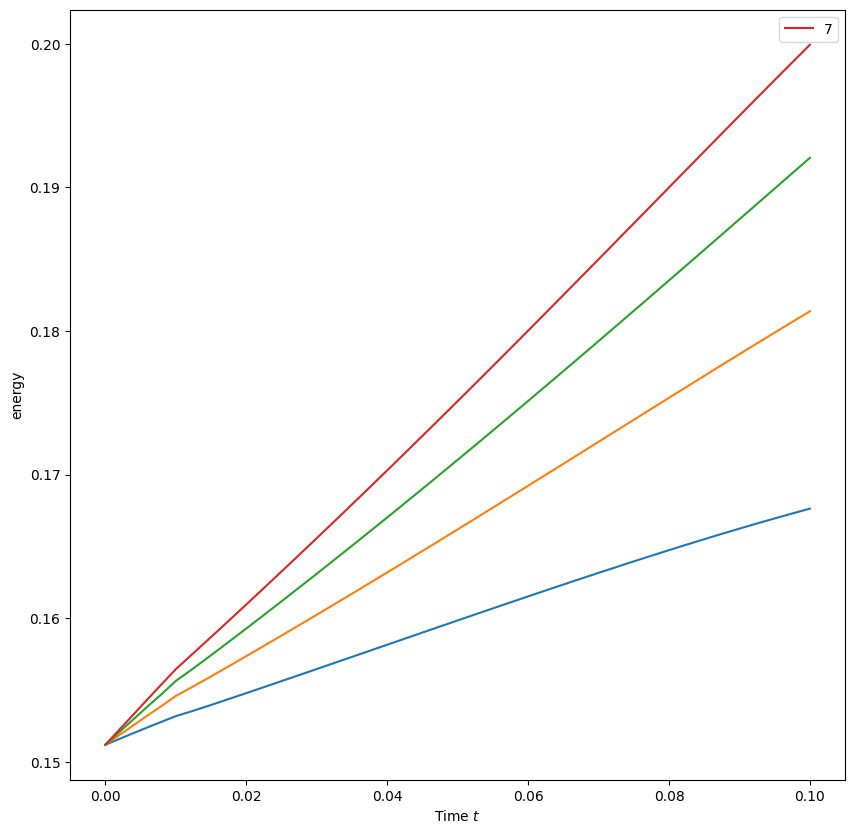

In [88]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(10,10))

axs1.plot(times, load_list("Corr_(t,U,m,J)=(1,1,1,0.5)") , label="")
axs1.plot(times, load_list("Corr_(t,U,m,J)=(1,1,1,1)") , label="")
axs1.plot(times, load_list("Corr_(t,U,m,J)=(1,1,1,1.5)") , label="")
axs1.plot(times, load_list("Corr_(t,U,m,J)=(1,1,1,2)") , label="7")

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("energy")  
axs1.legend()

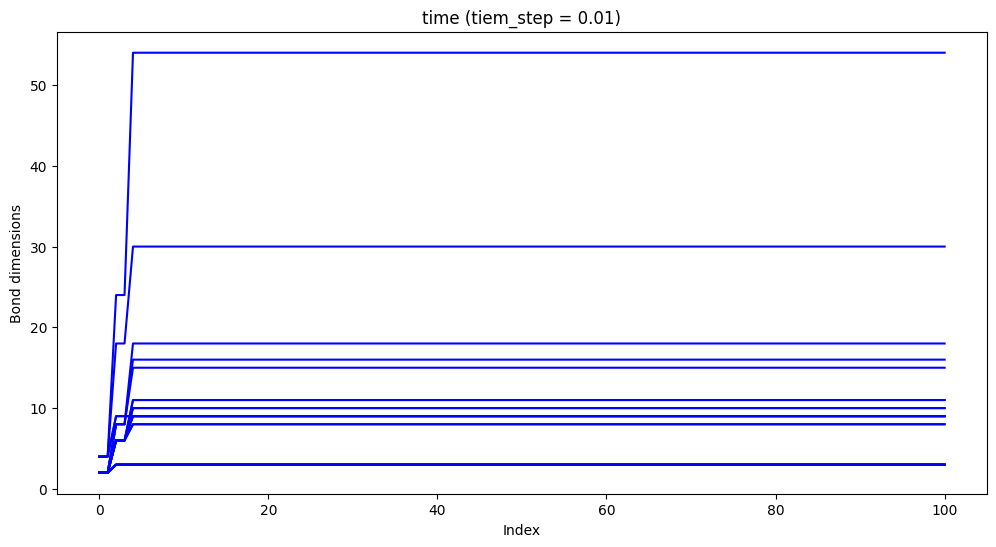

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

for key, values in tdvp_ex1.bond_dims.items():
    x = list(range(len(values)))
    ax.plot(x, values, color='blue')

#blue_patch = plt.Line2D([0], [0], color='blue', label='QR-split form (8 min)')

ax.set_xlabel('Index')
ax.set_ylabel('Bond dimensions')
ax.set_title('time (tiem_step = 0.01)')


plt.show()


In [ ]:
shapes = {
    (0, 0): (3, 4, 5, d),
    (0, 1): (3, 2, d),
    (0, 2): (2, 2, d),
    (1, 0): (4, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, d),
    (2, 0): (2, 2, d),
    (2, 1): (2, 2, 2, d),
    (2, 2): (2, d)
}


sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(3) for j in range(3)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0)]


for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

#ttn = product_state(ttn , bond_dim= 2, physical_dim = d)

nodes = {
    (i, j): (ptn.Node(tensor=ttn.tensors[f"Site({i},{j})"].conj() , identifier=f"Node({i},{j})"), ttn.tensors[f"Site({i},{j})"].conj()) for i in range(3) for j in range(3)
}

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 2, "Site(0,0)", 2)

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

    import pytreenet.contractions.state_operator_contraction as A
ptn.adjust_operator_to_ket(N1,ttn)
ptn.adjust_bra_to_ket(ttn)
dict = A.contract_all_except_root(ttn, N1)
ket_node, ket_tensor = ttn[ttn.root_id]
bra_id = ttn.nodes[ttn.root_id].neighbouring_nodes()[0]
_ , bra_tensor = ttn[bra_id]
ket_neigh_block = A.contract_all_neighbour_blocks_to_ket_Lindblad(ket_tensor,
                                                        ket_node,
                                                        dict)
ket_neigh_block.shape
perm = list(range(ket_neigh_block.ndim)) 
perm.append(perm.pop(1))
ket_neigh_block = ket_neigh_block.transpose(perm)
perm
op_node , op_tensor = N1[ttn.root_id]
op_neighbours = N1.nodes[ttn.root_id].neighbouring_nodes()
ket_node, ket_tensor = ttn[ttn.root_id]
ket_neighbours = ttn.nodes[ttn.root_id].neighbouring_nodes()

element_map = {elem: i for i, elem in enumerate(op_neighbours)}
permutation = tuple(element_map[elem] for elem in ket_neighbours)
nneighbours = ttn.nodes[ttn.root_id].nneighbours()
permutation = permutation + (len(permutation), len(permutation)+1)
op_tensor = np.transpose(op_tensor, permutation)
shape = list(op_tensor.shape)
shape.pop(0)
shape = tuple(shape)
op_tensor = np.reshape(op_tensor, shape)
ket_neigh_block.shape , op_tensor.shape
kethamblock = np.tensordot(ket_neigh_block, op_tensor,
                        axes=((1,3,5), (0,1,2)))
kethamblock.shape
state_legs = tuple(range(0, nneighbours+1))
state_legs
np.tensordot(bra_tensor, kethamblock,
                        axes=(state_legs,state_legs)) 

In [ ]:
from __future__ import annotations
from typing import List, Union
from copy import deepcopy
from tqdm import tqdm
import numpy as np
from ...operators.tensorproduct import TensorProduct
from ...ttno.ttno import TTNO
from ...ttns import TreeTensorNetworkState , normalize_ttn_Lindblad
from ..ttn_time_evolution import TTNTimeEvolutionConfig
from ..Subspace_expansion import expand_subspace , KrylovBasisMode , max_two_neighbour_form , original_form
from ...util.tensor_splitting import SplitMode , SVDParameters
from ...core.canonical_form import adjust_ttn1_structure_to_ttn2 , adjust_ttno_structure_to_ttn
from pytreenet.contractions.state_operator_contraction import adjust_operator_to_ket , adjust_bra_to_ket
from .onesitetdvp import OneSiteTDVP
from ...contractions.tree_cach_dict import PartialTreeCachDict
from ...time_evolution.time_evo_util.update_path import TDVPUpdatePathFinder


class SecondOrderOneSiteTDVP(OneSiteTDVP):
    """
    The first order one site TDVP algorithm.

    This means we have second order Trotter splitting for the time evolution:
      exp(At+Bt) approx exp(At/2)*exp(Bt/2)*exp(Bt/2)*exp(At/2)

    Has the same attributes as the TDVP-Algorithm clas with two additions.

    Attributes:
        backwards_update_path (List[str]): The update path that traverses
            backwards.
        backwards_orth_path (List[List[str]]): The orthogonalisation paths for
            the backwards run.
    """

    def __init__(self, initial_state: TreeTensorNetworkState,
                 hamiltonian: TTNO, time_step_size: float, final_time: float,
                 operators: Union[TensorProduct, List[TensorProduct]],
                 num_vecs: int = 3, 
                 tau: float = 1e-2, 
                 SVDParameters : SVDParameters = SVDParameters(),
                 expansion_steps: int = 10,
                 initial_tol: float = 1e-5,
                 tol_step: float = 1e-1, 
                 max_bond: int = 32, 
                 norm_tol: float = np.inf,
                 KrylovBasisMode : KrylovBasisMode = KrylovBasisMode.apply_ham,                  
                 config: Union[TTNTimeEvolutionConfig,None] = None) -> None:
        """
        Initialize the second order one site TDVP algorithm.

        Args:
            initial_state (TreeTensorNetworkState): The initial state of the
                system.
            hamiltonian (TTNO): The Hamiltonian of the system.
            time_step_size (float): The time step size.
            final_time (float): The final time of the evolution.
            operators (Union[TensorProduct, List[TensorProduct]]): The operators
                for which the expectation values are calculated.
            config (Union[TTNTimeEvolutionConfig,None], optional): The time
                evolution configuration. Defaults to None.
        """
        super().__init__(initial_state, hamiltonian,
                         time_step_size, final_time, operators, num_vecs, 
                         tau,
                         SVDParameters,
                         expansion_steps,
                         initial_tol,
                         tol_step,
                         max_bond,
                         KrylovBasisMode,  
                         config)
        self.norm_tol = norm_tol
        self.backwards_update_path = self._init_second_order_update_path()
        self.backwards_orth_path = self._init_second_order_orth_path()
        self.state , self.hamiltonian = self._init_two_neighbour_form()

    def _init_two_neighbour_form(self):
        """
        Transform the state and the Hamiltonian into the max two neighbour form.
        """
        # adjust_operator_to_ket(self.hamiltonian , self.state)
        self.hamiltonian = adjust_ttno_structure_to_ttn(self.hamiltonian , self.state)
        self.state , dict1 = max_two_neighbour_form(self.state)
        self.hamiltonian , dict2 = max_two_neighbour_form(self.hamiltonian , dict1)
        #self.hamiltonian = adjust_ttno_structure_to_ttn(tdvp_ex1.hamiltonian , tdvp_ex1.state)
        assert dict1 == dict2
        self.partial_tree_cache = PartialTreeCachDict()
        self._init_partial_tree_cache()
        self.update_path = TDVPUpdatePathFinder(self.state).find_path()
        self.orthogonalization_path = self._find_tdvp_orthogonalization_path(self.update_path) 
        self.backwards_update_path = self._init_second_order_update_path()
        self.backwards_orth_path = self._init_second_order_orth_path() 
        self.two_neighbour_form_dict = dict1
        return self.state , self.hamiltonian
    
    def _init_second_order_update_path(self) -> List[str]:
        """
        Find the update path that traverses backwards.
        """
        return list(reversed(self.update_path))

    def _init_second_order_orth_path(self) -> List[List[str]]:
        """
        Find the orthogonalisation paths for the backwards run.
        """
        back_orthogonalization_path = []
        for i, node_id in enumerate(self.backwards_update_path[1:-1]):
            current_path = self.state.path_from_to(node_id,
                                                   self.backwards_update_path[i+2])
            current_path = current_path[:-1]
            back_orthogonalization_path.append(current_path)
        back_orthogonalization_path.append([self.backwards_update_path[-1]])
        return back_orthogonalization_path

    def _update_forward_site_and_link(self, node_id: str,
                                      next_node_id: str):
        """
        Run the forward update with half time step.

        First the site tensor is updated and then the link tensor.

        Args:
            node_id (str): The identifier of the site to be updated.
            next_node_id (str): The other node of the link to be updated.
        """
        assert self.state.orthogonality_center_id == node_id
        self._update_site(node_id,
                          time_step_factor=0.5)
        self._update_link(node_id, next_node_id,
                          time_step_factor=0.5)

    def forward_sweep(self):
        """
        Perform the forward sweep through the state.
        """
        for i, node_id in enumerate(self.update_path[:-1]):
            # Orthogonalize
            if i>0:
                self._move_orth_and_update_cache_for_path(self.orthogonalization_path[i-1])
            # Select Next Node
            next_node_id = self.orthogonalization_path[i][0]
            # Update
            self._update_forward_site_and_link(node_id, next_node_id)

    def _final_forward_update(self):
        """
        Perform the final forward update. 
        
        To save some computation, the update is performed with a full time
        step. Since the first update backwards occurs on the same node. We
        also do not need to update any link tensors.
        """
        node_id = self.update_path[-1]
        assert node_id == self.backwards_update_path[0]
        assert self.state.orthogonality_center_id == node_id
        self._update_site(node_id)

    def _update_first_backward_link(self):
        """
        Update the link between the first and second node in the backwards
        update path with a half time step.
        
        We have already updated the first site on the backwards update path
        and the link will always be next to it, so the orthogonality center
        is already at the correct position.
        """
        next_node_id = self.backwards_update_path[1]
        self._update_link(self.state.orthogonality_center_id,
                          next_node_id,
                          time_step_factor=0.5)

    def _normal_backward_update(self, node_id: str,
                                update_index: int):
        """
        The normal way to make a backwards update.
        
        First the site tensor is updated. Then the orthogonality center is
        moved, if needed. Finally the link tensor between the new
        orthogonality center and the next node is updated. 
        
        Args:
            node_id (str): The identifier of the site to be updated.
            update_index (int): The index of the update in the backwards
                update path.
        """
        assert self.state.orthogonality_center_id == node_id
        self._update_site(node_id, time_step_factor=0.5)
        new_orth_center = self.backwards_orth_path[update_index-1]
        self._move_orth_and_update_cache_for_path(new_orth_center)
        next_node_id = self.backwards_update_path[update_index+1]
        self._update_link(self.state.orthogonality_center_id,
                          next_node_id,
                          time_step_factor=0.5)

    def _final_backward_update(self):
        """
        Perform the final backward update.
        
        Since this is the last node that needs updating, no link update is
        required afterwards.
        """
        node_id = self.backwards_update_path[-1]
        assert self.state.orthogonality_center_id == node_id
        self._update_site(node_id, time_step_factor=0.5)

    def backward_sweep(self):
        """
        Perform the backward sweep through the state.
        """
        self._update_first_backward_link()
        for i, node_id in enumerate(self.backwards_update_path[1:-1]):
            self._normal_backward_update(node_id, i+1)
        self._final_backward_update()

    def run_one_time_step(self):
        """
        Run a single second order time step.
        
        This mean we run a full forward and a full backward sweep through the
        tree.
        """
        self.forward_sweep()
        self._final_forward_update()
        self.backward_sweep()


    def forward_sweep_ex(self):
        """
        Perform the forward sweep through the state.
        """
        for i, node_id in enumerate(self.update_path[:-1]):
            # Orthogonalize
            if i>0:
                self._move_orth_and_update_cache_for_path(self.orthogonalization_path[i-1])
            # Select Next Node
            next_node_id = self.orthogonalization_path[i][0]
            # Update
            self._update_forward_site_and_link(node_id, next_node_id)

    def run_one_time_step_ex(self):
        """
        Run a single second order time step.
        
        This mean we run a full forward and a full backward sweep through the
        tree.
        """

        self.forward_sweep_ex()
        self._final_forward_update()
        self.backward_sweep()  
    

    def run_ex(self, evaluation_time: Union[int,"inf"] = 1, filepath: str = "",
            pgbar: bool = True,):
        """
        Runs this time evolution algorithm for the given parameters.

        The desired operator expectation values are evaluated and saved.

        Args:
            evaluation_time (int, optional): The difference in time steps after which
                to evaluate the operator expectation values, e.g. for a value of 10
                the operators are evaluated at time steps 0,10,20,... If it is set to
                "inf", the operators are only evaluated at the end of the time.
                Defaults to 1.
            filepath (str, optional): If results are to be saved in an external file,
                the path to that file can be specified here. Defaults to "".
            pgbar (bool, optional): Toggles the progress bar. Defaults to True.
        """
      
        self._init_results(evaluation_time)
        assert self._results is not None
        tol_step = -1
        for i in tqdm(range(self.num_time_steps + 1), disable=not pgbar):
            if i != 0:  # We also measure the initial expectation_values   

                ###########
                tol_step += 1
                if i % self.expansion_steps == 0 :
                    if state_bond.max_bond_dim() < self.max_bond:
                        tol = self.initial_tol * self.tol_step ** tol_step
                        state_ex = expand_subspace(state_ex, self.hamiltonian, 
                                                    self.num_vecs, self.tau, 
                                                    self.SVDParameters, tol, self.KrylovBasisMode)
                        self.state = state_ex
                        self.state.move_orthogonalization_center(self.update_path[0],mode = SplitMode.KEEP)
                        self.partial_tree_cache = PartialTreeCachDict()
                        self._init_partial_tree_cache()
                    else:
                        assert self.state.orthogonality_center_id == self.update_path[0]   
                ##########

                self.run_one_time_step_ex() 
                state_ex = deepcopy(self.state) 
            ttn = deepcopy(self.state)
            ttn = original_form(ttn , self.two_neighbour_form_dict)
            I = TTNO.Identity(ttn)
            I_ex = ttn.operator_expectation_value_Lindblad(I)
            if np.abs(I_ex - 1) > self.norm_tol :
                self.state = normalize_ttn_Lindblad(ttn) 
                norm = 1
                if evaluation_time != "inf" and i % evaluation_time == 0 and len(self._results) > 0:
                    index = i // evaluation_time
                    current_results = self.evaluate_operators() / np.sqrt(norm)
                    self._results[0:-1, index] = current_results
                    # Save current time
                    self._results[-1, index] = i*self.time_step_size

                max_two_neighbour_form(self.state , self.two_neighbour_form_dict)
                
                self._orthogonalize_init()
                self.partial_tree_cache = PartialTreeCachDict()
                self._init_partial_tree_cache()     
            else:
                norm = I_ex               
                if evaluation_time != "inf" and i % evaluation_time == 0 and len(self._results) > 0:
                    index = i // evaluation_time
                    current_results = self.evaluate_operators() / np.sqrt(norm)
                    self._results[0:-1, index] = current_results
                    # Save current time
                    self._results[-1, index] = i*self.time_step_size  
            state_bond = deepcopy(self.state)
            self.record_bond_dimensions()
        
        if evaluation_time == "inf":
            current_results = self.evaluate_operators()
            self._results[0:-1, 0] = current_results
            self._results[-1, 0] = i*self.time_step_size
        if filepath != "":
            self.save_results_to_file(filepath)        #   